In [1]:
import numpy as np
import sympy as sym
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.integrate import solve_ivp

In [2]:
#Constants
t_step = 1800; #Step size
J_2 = 0.00108; #Perturbation constant
Rearth = 6370; #Radius of big body (km)
mu_E = 398600; #Gravitational parameter (km^3/s^2)
a = 26600; #Semi-major axis (km)
e = 0.74; #Eccentricity
i = 1.10654; #Inclination (rad)
w = 5 * np.pi/180; #Argument of perigee (rad)
omega = 90 * np.pi/180; #Right ascension of longitudinal node (rad)
M = 10 * np.pi/180; #Initial mean anomaly (rad)
E_0 = M; #Initial eccentric anomaly guess (rad)
g = 1;
itr = 0;

In [3]:
#Orbital elements
#Iterate to get actual eccentric anomaly
while np.abs(g) > 1e-10:
    g = E_0 - e*np.sin(E_0) - M;
    dg_dE = 1 - e*np.cos(E_0);
    E_1 = E_0 - g/dg_dE;
    E_0 = E_1;
    itr = itr + 1;
H_0 = (mu_E*a*(1-e**2))**0.5; #Initial angular momentum magnitude (km^2/s)
r_P = a*(1-e); #Perigee altitude (km)
r_A = a*(1+e); #Apogee altitude (km)
n = np.sqrt(mu_E/(a**3)); #Mean motion (s^-1)
P = (2*np.pi)/n; #Period (s)
T = 100*24*60*60; #Final time (s)
f = 2*math.atan(((1+e)/(1-e))**0.5 * np.tan(E_1/2)); #Anomaly (rad)
theta = w + f; #True anomaly (rad)

In [4]:
#Orbital elements to r and v vectors
R_0 = (H_0**2/mu_E)/(1 + e*np.cos(f));
r1 = R_0*(np.cos(theta)*np.cos(omega) - np.cos(i)*np.sin(omega)*np.sin(theta));
r2 = R_0*(np.cos(theta)*np.sin(omega) + np.cos(i)*np.cos(omega)*np.sin(theta));
r3 = R_0*(np.sin(i)*np.sin(theta));
r_0 = np.array([r1,r2,r3]);
v1 = (-mu_E/H_0)*(np.cos(omega)*(np.sin(theta) + e*np.sin(w)) + np.sin(omega)*(np.cos(theta) + e*np.cos(w))*np.cos(i));
v2 = (-mu_E/H_0)*(np.sin(omega)*(np.sin(theta) + e*np.sin(w)) - np.cos(omega)*(np.cos(theta) + e*np.cos(w))*np.cos(i));
v3 = (mu_E/H_0)*((np.cos(theta) + e*np.cos(w))*np.sin(i));
v_0 = np.array([v1,v2,v3]);
V_0 = np.linalg.norm(v_0);

In [5]:
#Perturbation vector
pp1 = (3/2)*((J_2*mu_E*(Rearth**2))/(R_0**4));
pp2 = 5*((r3/R_0)**2) - 1;
pp3 = 5*((r3/R_0)**2) - 3;
p1 = pp1*np.array([(r1/R_0)*pp2,(r2/R_0)*pp2,(r3/R_0)*pp3]);
P1 = np.linalg.norm(p1);

In [6]:
#Iterate the solver
t_plot = np.arange(0,T,t_step);
x_plot = np.array([r_0[0], r_0[1], r_0[2], v_0[0], v_0[1], v_0[2]]);
def func(t_1, x_plot):
    J_2 = 0.00108;
    Rearth = 6370;
    mu_E = 398600;
    r = np.linalg.norm(x_plot[0:3])
    pp1 = (3/2)*((J_2*mu_E*(Rearth**2))/((r)**4));
    pp2 = 5*(((x_plot[2])/(r))**2) - 1;
    pp3 = 5*(((x_plot[2])/(r))**2) - 3;
    p1 = pp1*np.array([((x_plot[0])/(r))*pp2,((x_plot[1])/(r))*pp2,((x_plot[2])/(r))*pp3]);
    xdot = np.zeros(6);
    xdot[0] = x_plot[3];
    xdot[1] = x_plot[4];
    xdot[2] = x_plot[5];
    xdot[3] = -mu_E*((x_plot[0])/((r)**3)) + p1[0];
    xdot[4] = -mu_E*((x_plot[1])/((r)**3)) + p1[1];
    xdot[5] = -mu_E*((x_plot[2])/((r)**3)) + p1[2];
    return xdot
sol = solve_ivp(func, [0, T], x_plot, dense_output = True, rtol = 1e-13, atol = 1e-10);

In [7]:
#Orbital element plots
s = sol.sol(t_plot);
s = s.T;
a_elm = np.zeros_like(s);
E_elm = np.zeros_like(s);
i_elm = np.zeros_like(s);
omega_elm = np.zeros_like(s);
w_elm = np.zeros_like(s);
for i in range(len(s)):
    r_elm = np.array([s[i,0], s[i,1], s[i,2]]);
    R_elm = np.linalg.norm(r_elm, axis = 0);
    v_elm = np.array([s[i,3], s[i,4], s[i,5]]);
    V_elm = np.linalg.norm(v_elm, axis = 0);
    e_elm_1 = np.dot(r_elm,v_elm);
    e_elm = (((V_elm**2/mu_E) - (1/R_elm))*r_elm) - ((1/mu_E)*(e_elm_1)*v_elm);
    a_elm[i] = 1/((2/R_elm) - (V_elm**2/mu_E));
    h_elm = np.cross(r_elm,v_elm);
    H_elm = np.linalg.norm(h_elm);
    E_elm[i] = np.linalg.norm(e_elm);
    n_elm = np.array([-h_elm[1]/H_elm,h_elm[0]/H_elm,0]);
    N_elm = np.linalg.norm(n_elm);
    omega_check = n_elm[1];
    w_check = e_elm[2];
    i_elm[i] = np.arccos(h_elm[2]/H_elm);
    omega_elm[i] = np.arccos(n_elm[0]/N_elm);
    w_elm[i] = np.arccos((np.dot(n_elm,e_elm))/(N_elm*E_elm[i]));

(0, 4)

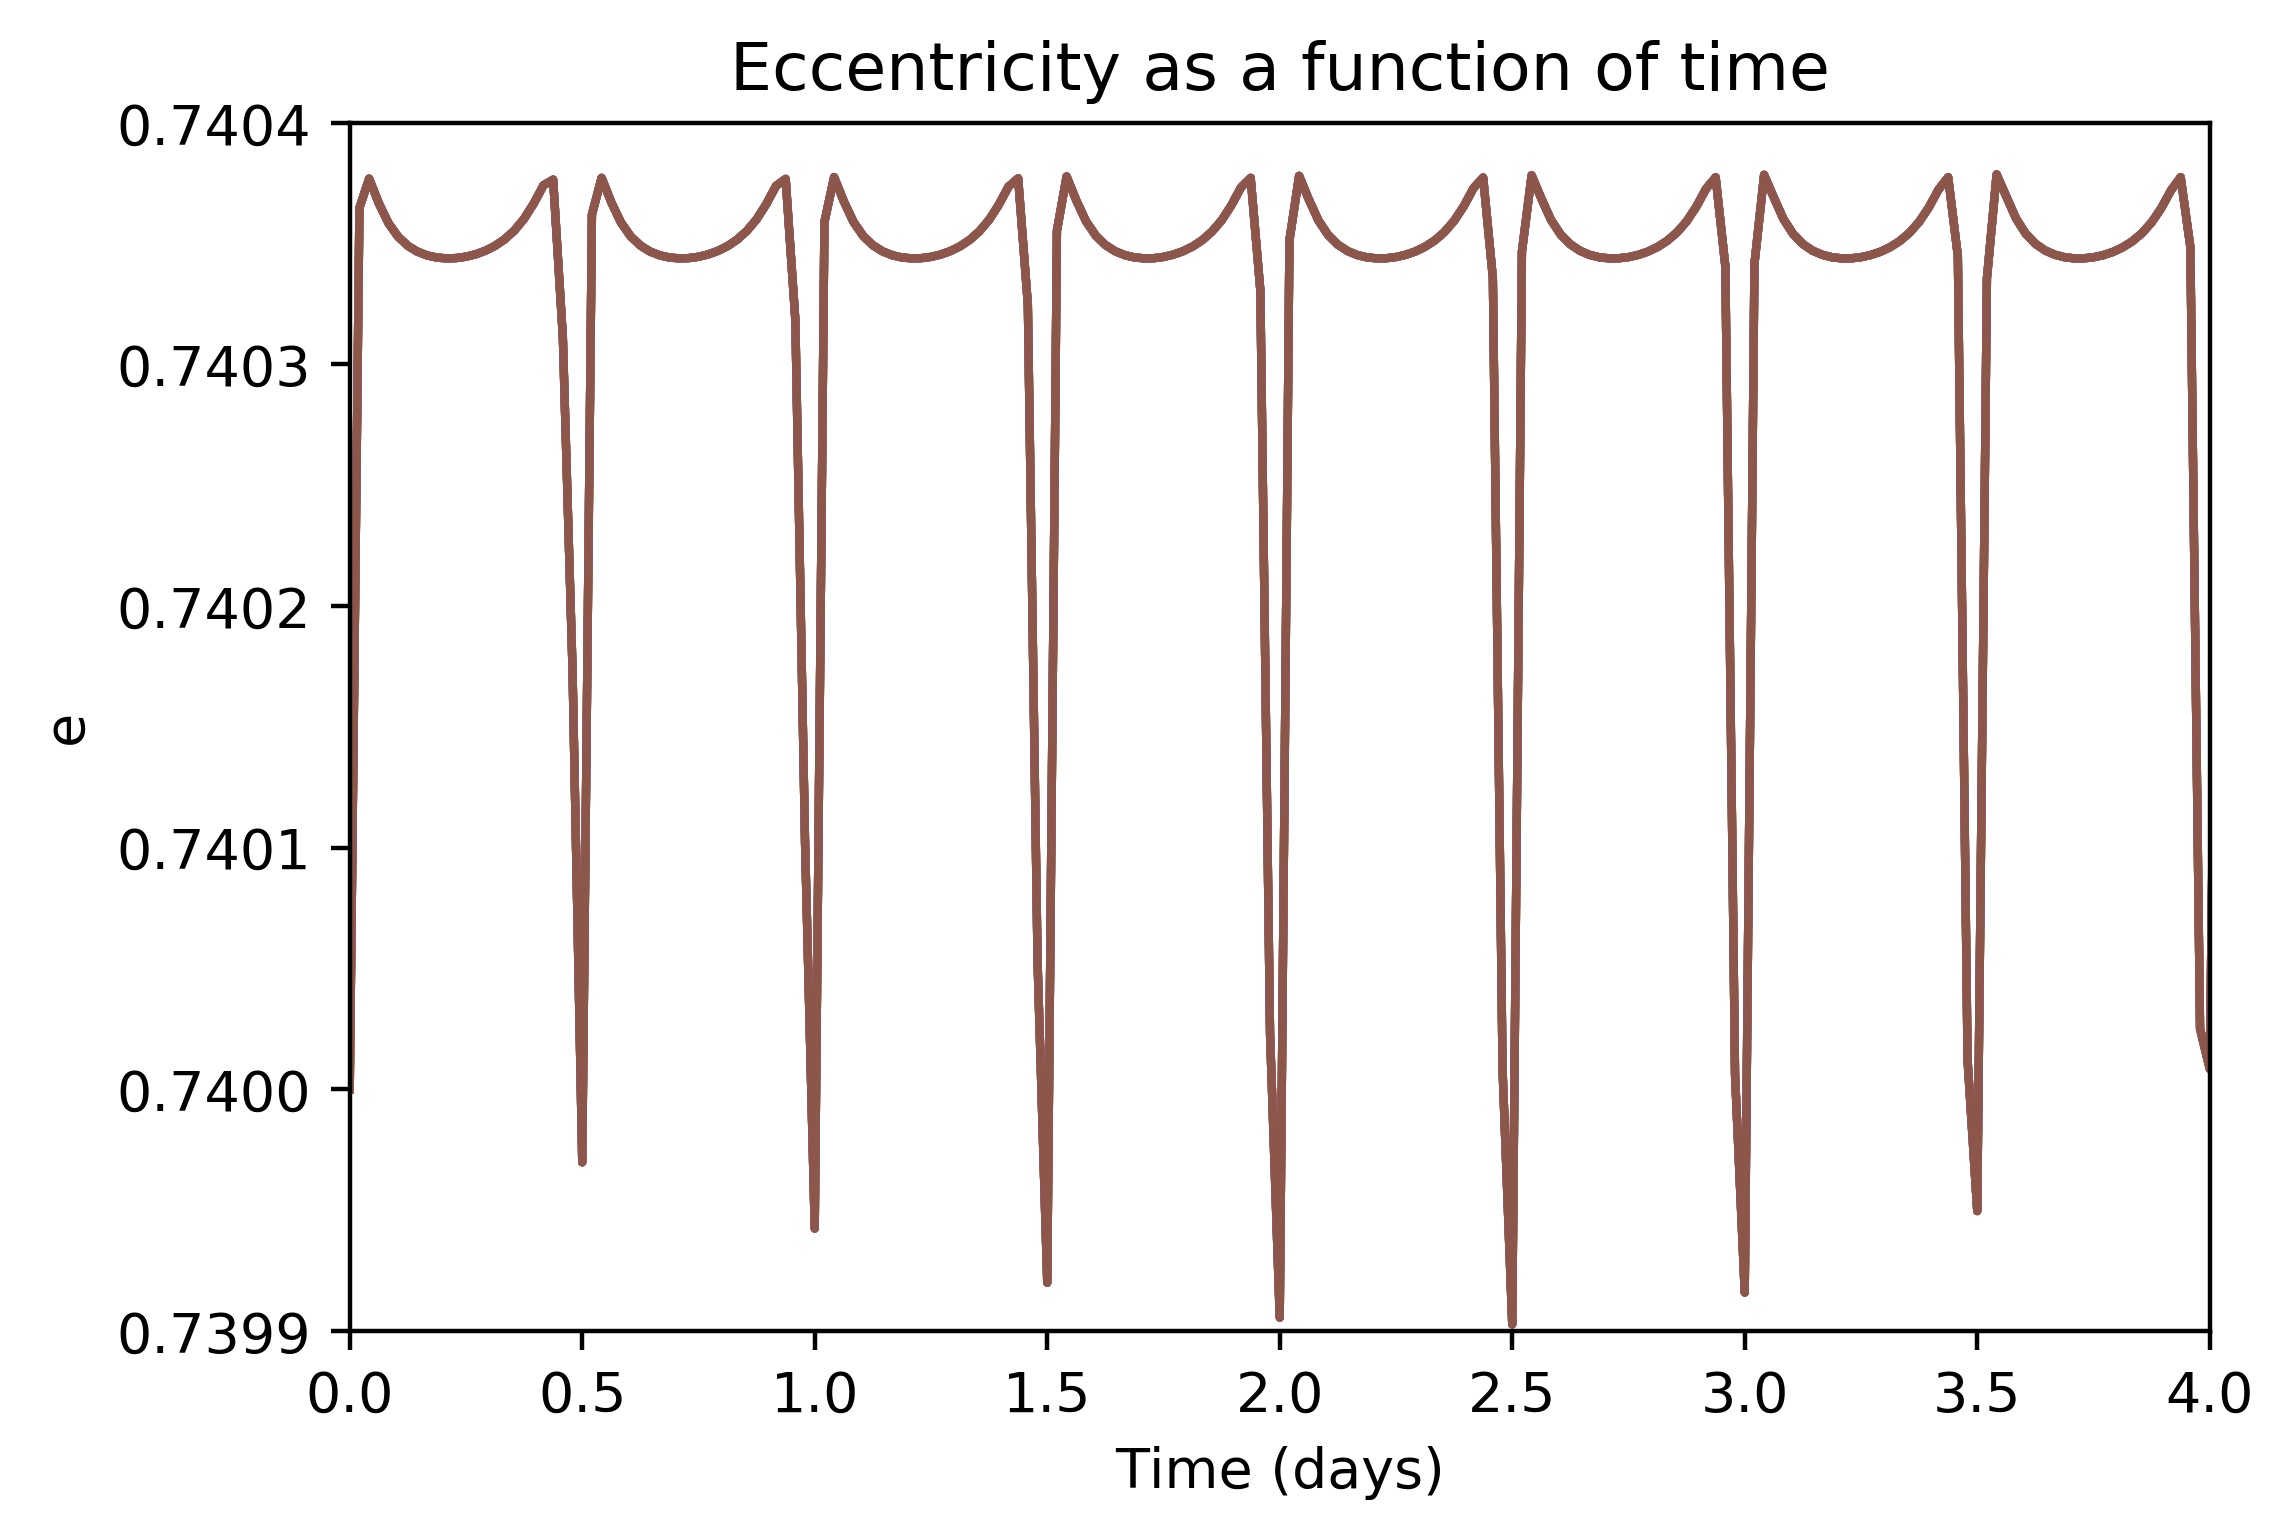

In [31]:
#Eccentricity plot
fig = plt.figure(dpi=400)
plt.title("Eccentricity as a function of time")
plt.plot(t_plot / 60 / 60 / 24, E_elm)
plt.xlabel('Time (days)')
plt.ylabel('e')
plt.ylim(0.7399,0.7404)
plt.xlim(0,4)
#0.74034 to 0.74038

(0, 4)

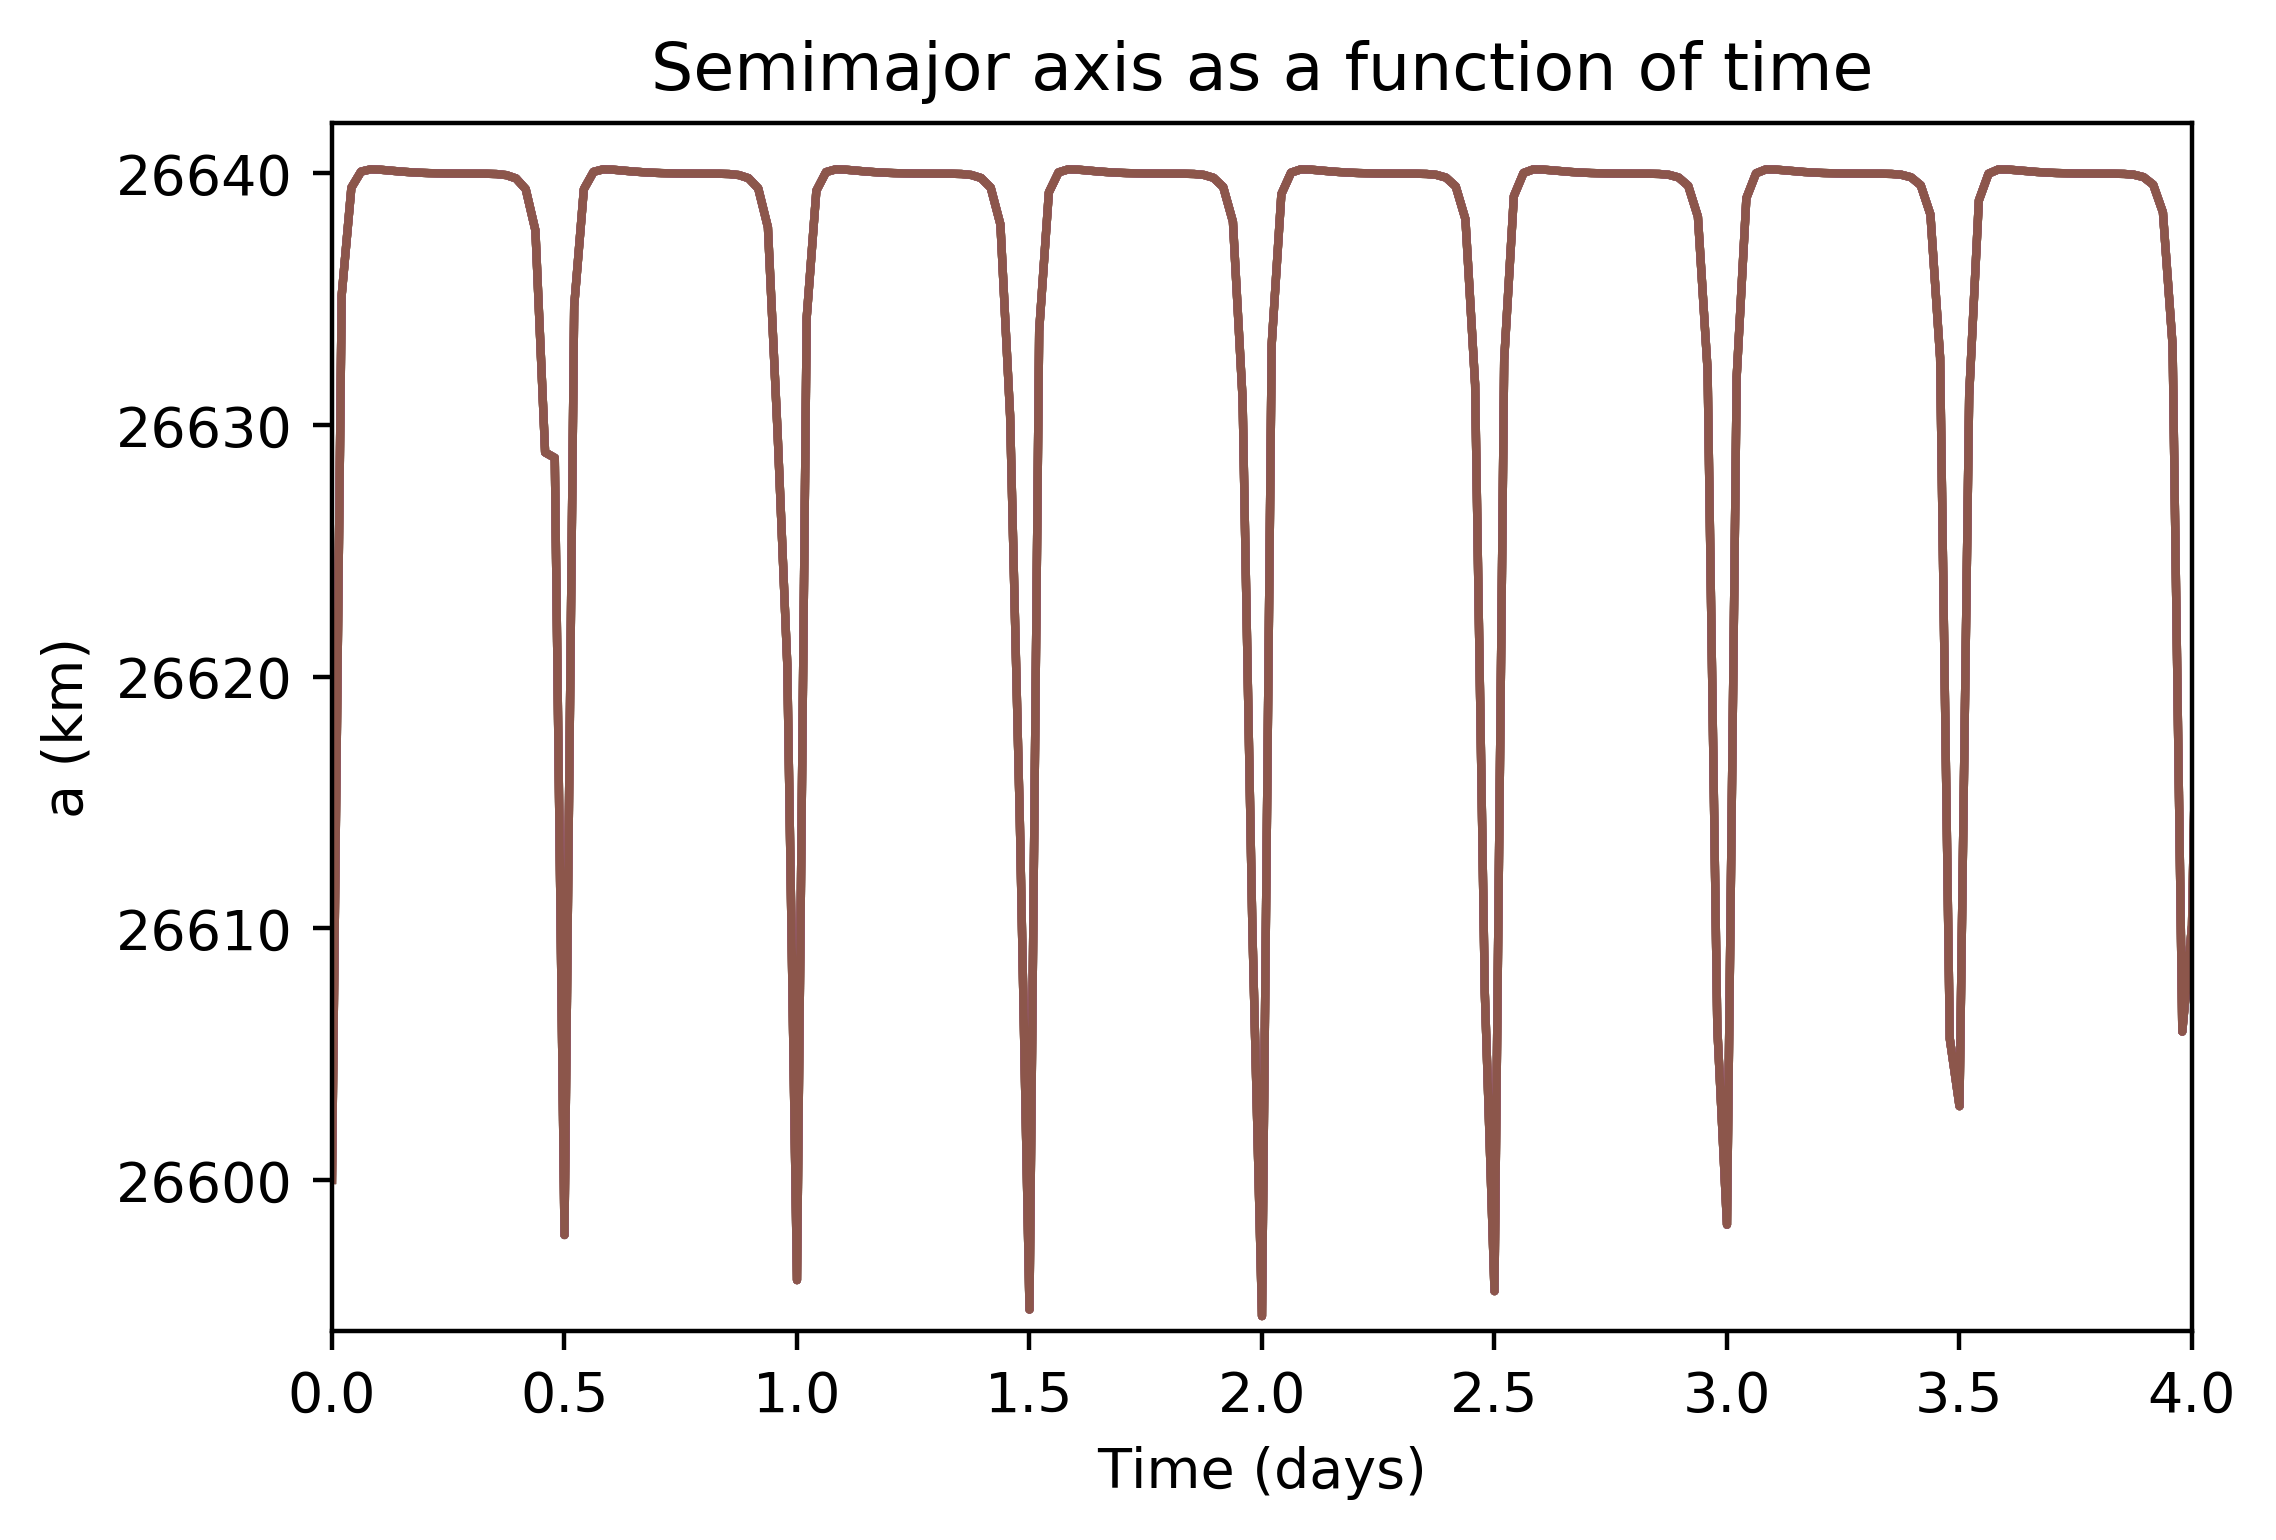

In [32]:
#Semimajor axis plot
fig = plt.figure(dpi=400)
plt.title("Semimajor axis as a function of time")
plt.plot(t_plot / 60 / 60 / 24, a_elm)
plt.xlabel('Time (days)')
plt.ylabel('a (km)')
plt.ylim(26594,26642)
plt.xlim(0,4)
#26,633 to 26,640

(0, 4)

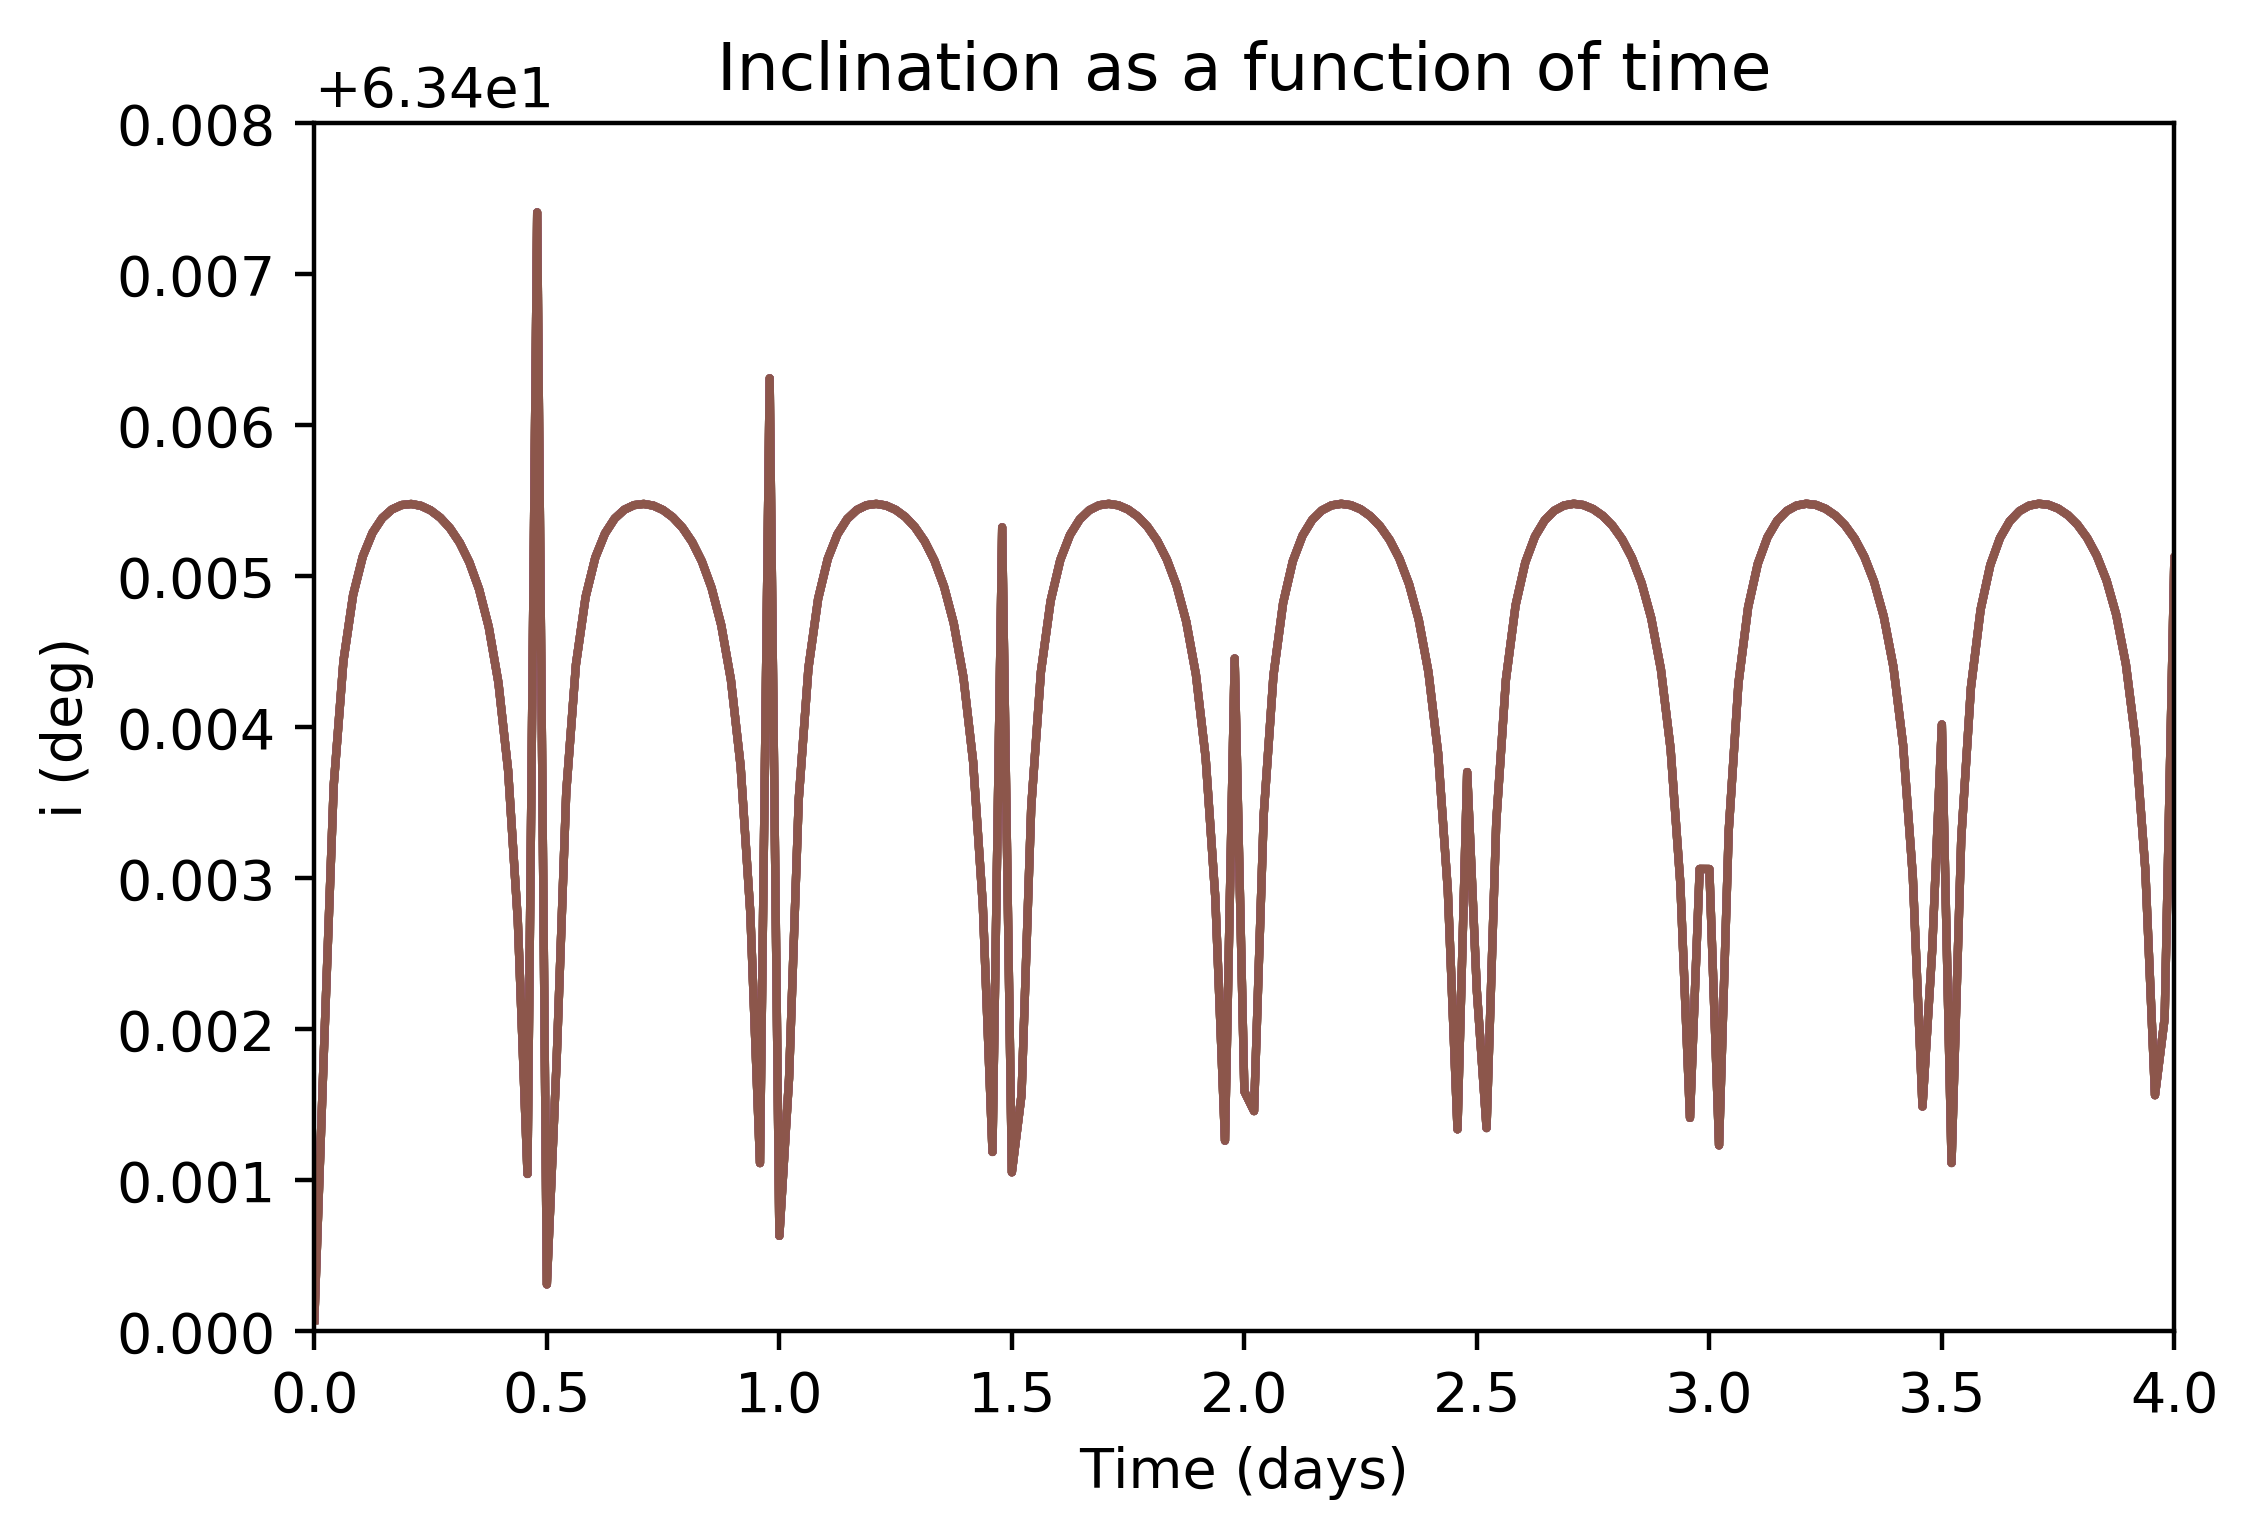

In [33]:
#Inclination plot
fig = plt.figure(dpi=400)
plt.title("Inclination as a function of time")
plt.plot(t_plot / 60 / 60 / 24, i_elm*(180/np.pi))
plt.xlabel('Time (days)')
plt.ylabel('i (deg)')
plt.ylim(63.400,63.408)
plt.xlim(0,4)
#63.401 to 63.406

(89.4, 90)

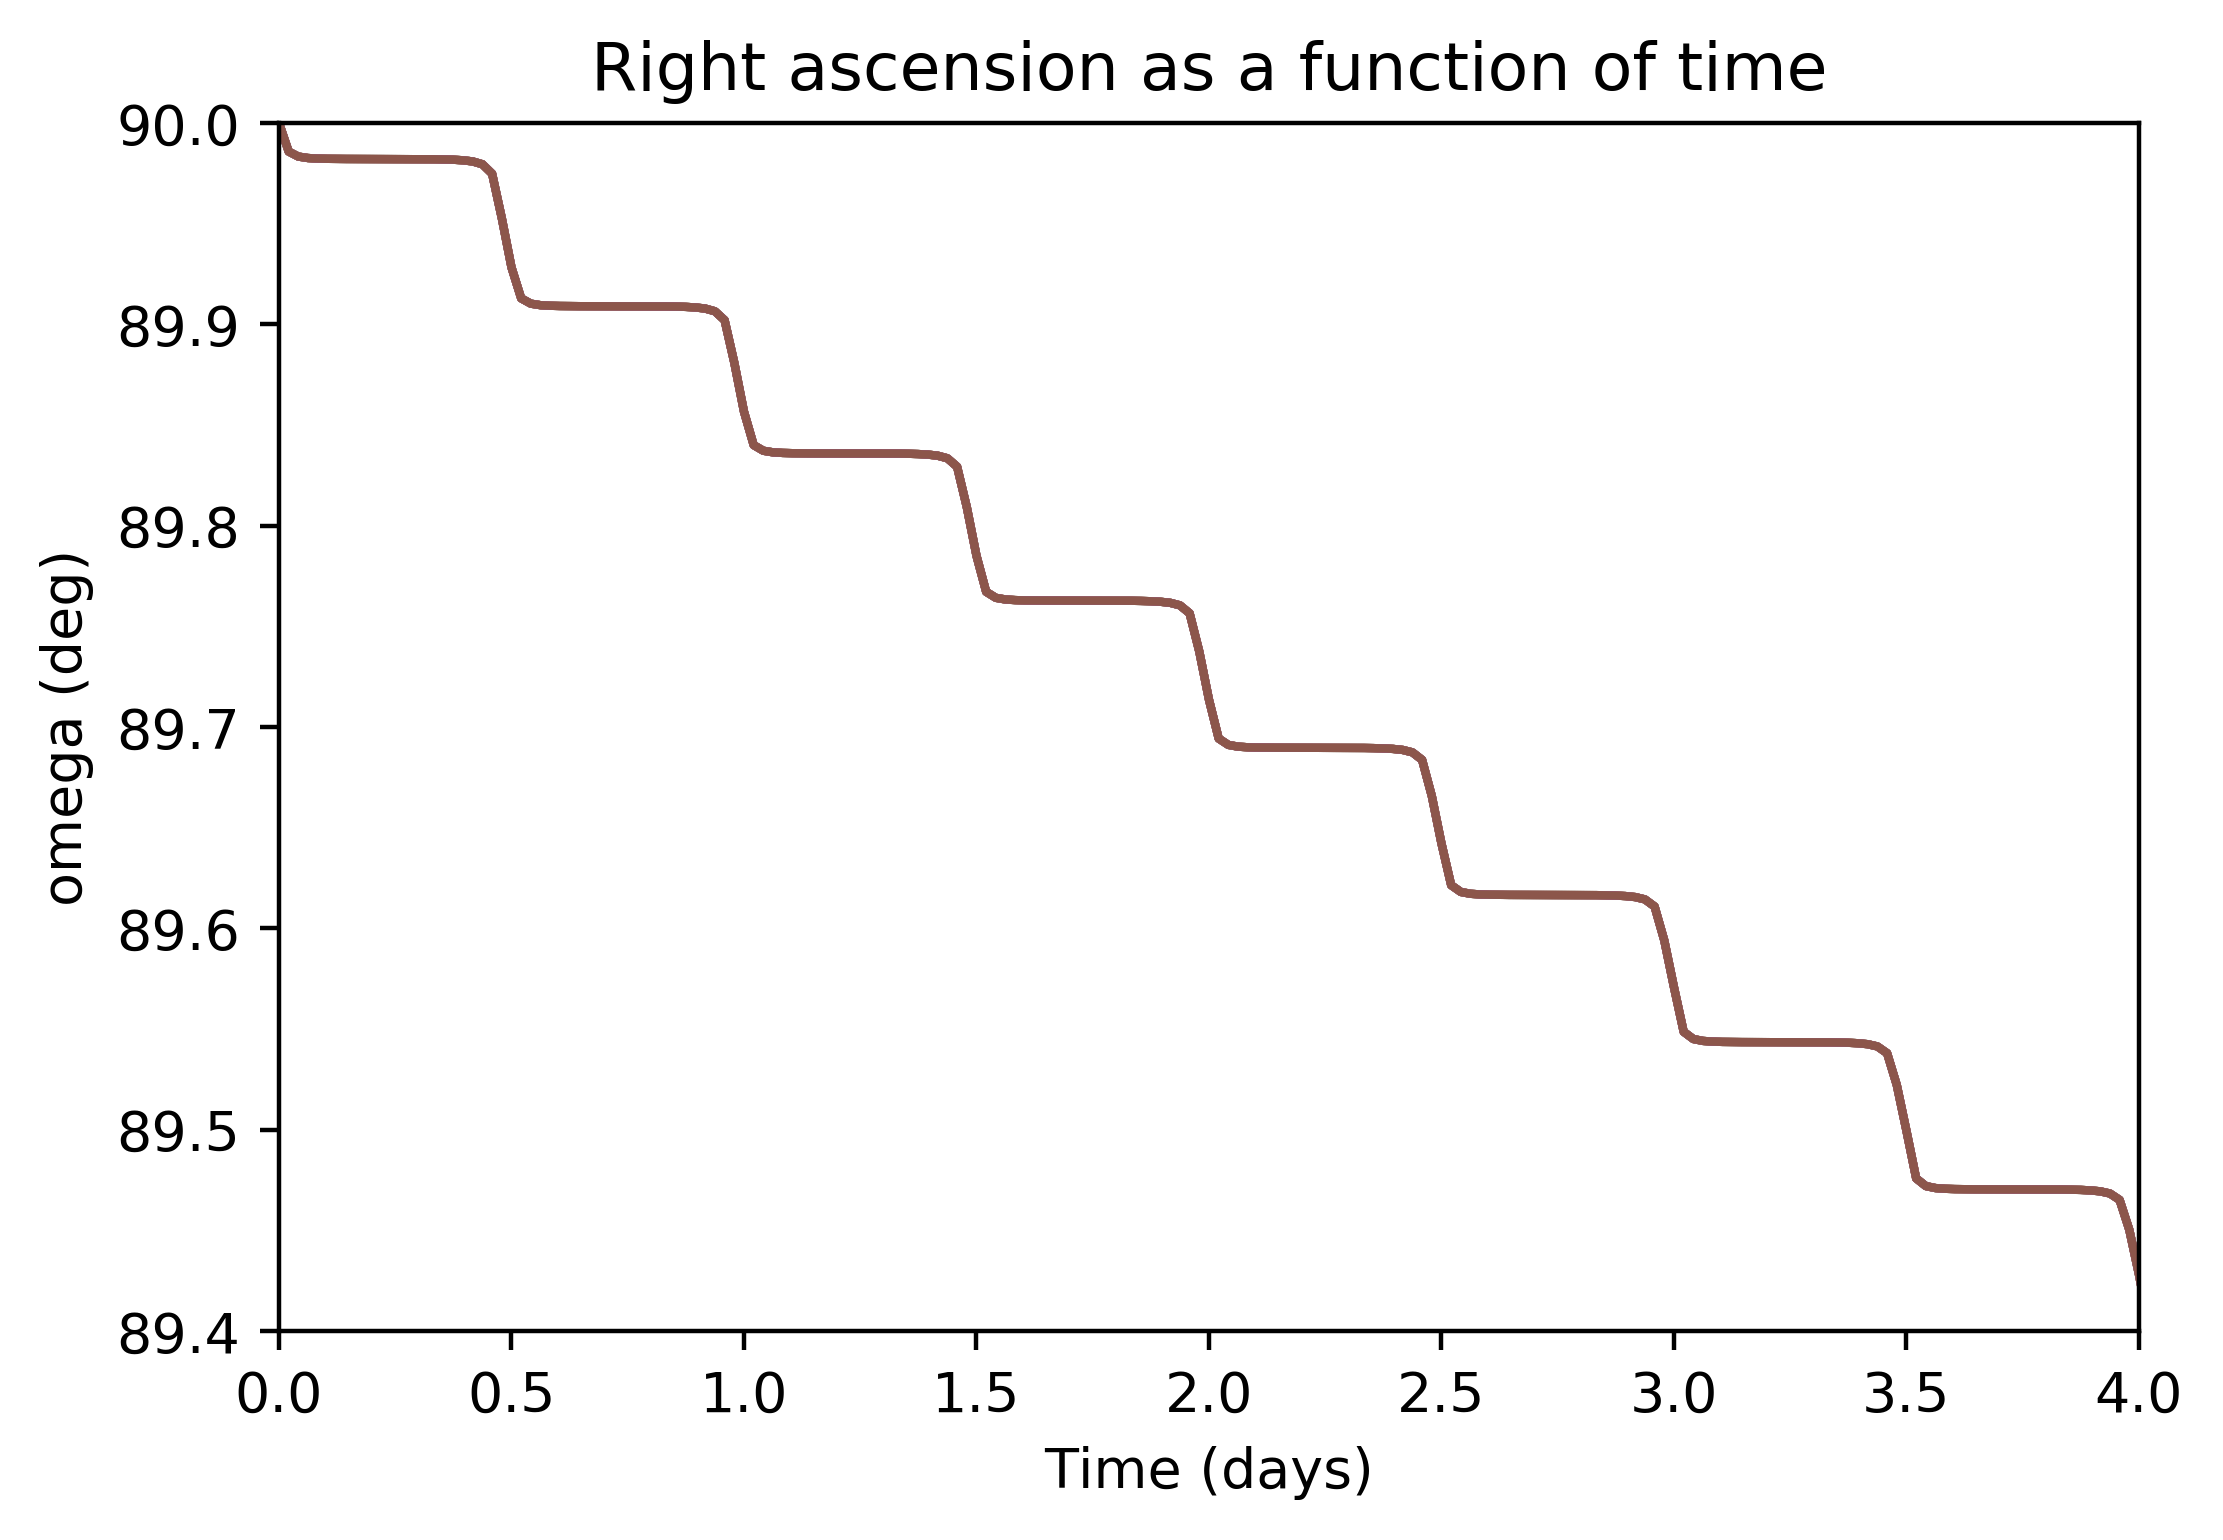

In [34]:
#Right ascension plot
fig = plt.figure(dpi=400)
plt.title("Right ascension as a function of time")
plt.plot(t_plot / 60 / 60 / 24, omega_elm*(180/np.pi))
plt.xlabel('Time (days)')
plt.ylabel('omega (deg)')
plt.xlim(0,4)
plt.ylim(89.4,90)

(5.0, 5.05)

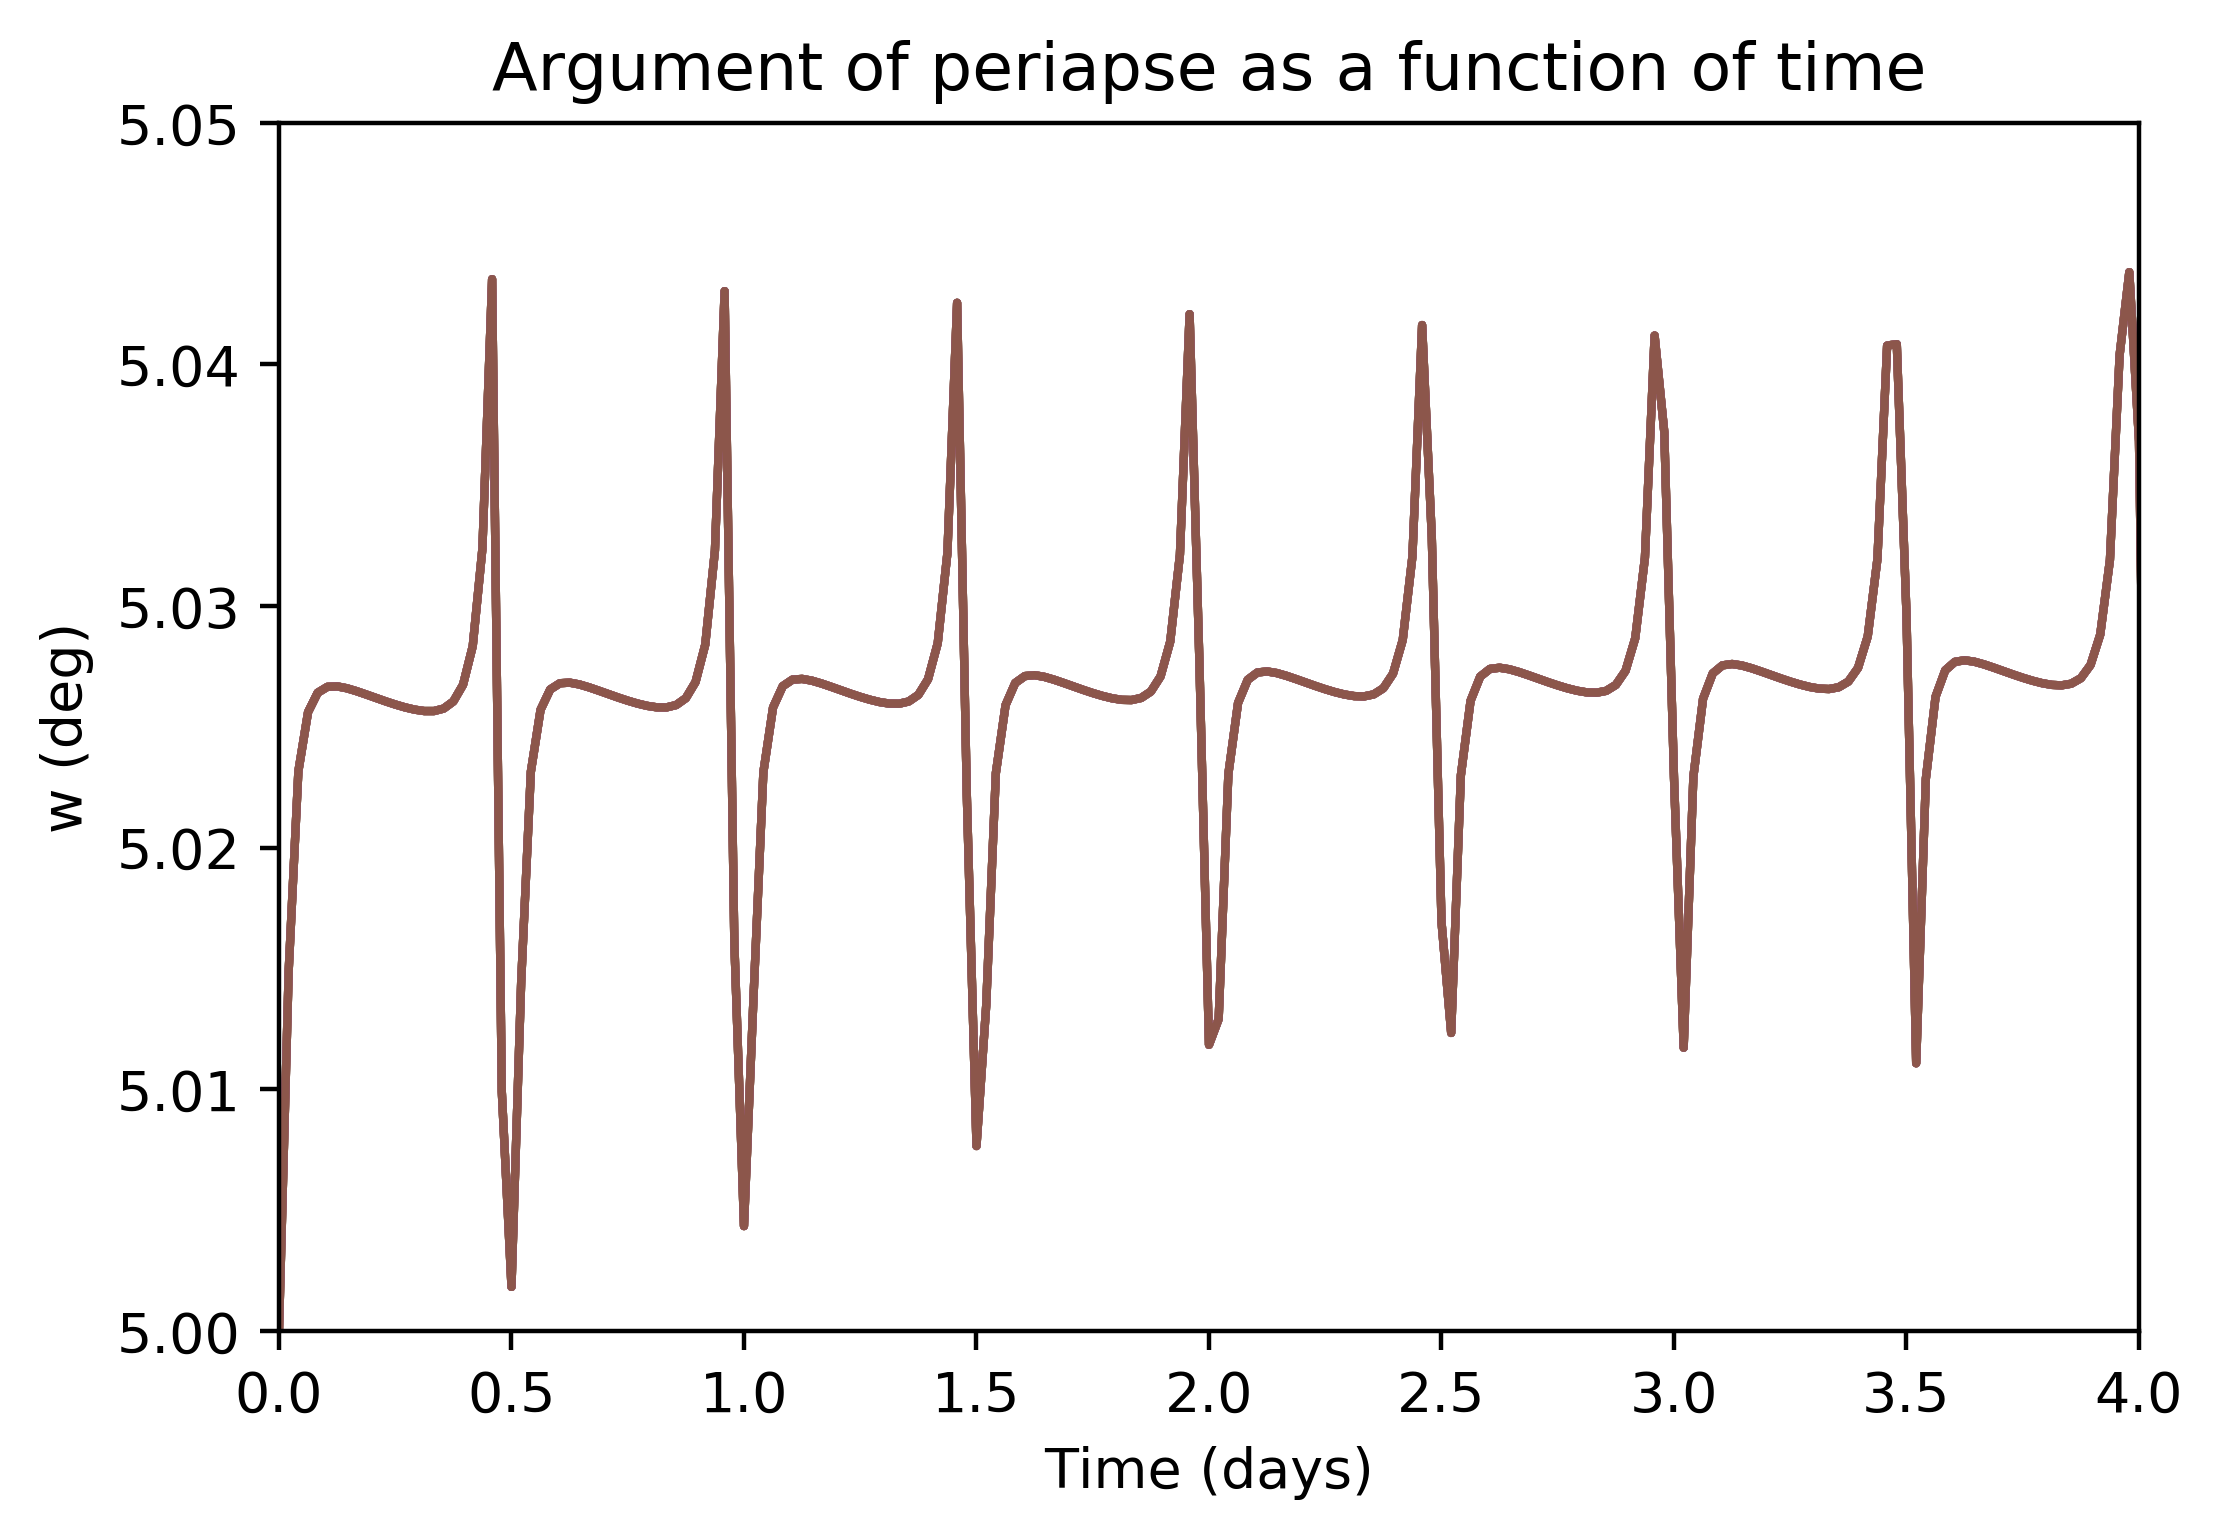

In [35]:
#Argument of periapse plot
fig = plt.figure(dpi=400)
plt.title("Argument of periapse as a function of time")
plt.plot(t_plot / 60 / 60 / 24, w_elm*(180/np.pi))
plt.xlabel('Time (days)')
plt.ylabel('w (deg)')
plt.xlim(0,4)
plt.ylim(5.00,5.05)